In [20]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [21]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")
nyt_df = pd.read_csv("data/nytimes_blm.csv")

wiki_df = pd.read_csv("data/wiki_blm.csv")


dfs = [ccc_df, ele_df, cl_df, wiki_df, nyt_df]

In [22]:
df = pd.concat(dfs).reset_index(drop=True)
display(df)

,id,date,city_st,location,size,size_str,urls,collection,Unnamed: 0
0,NaN,2020-05-30,"Hood River, OR","State St and 4th Streed, Hood River, OR",250.0,250,['https://www.hoodrivernews.com/news/rally-sil...,CCC,NaN
1,NaN,2020-05-25,"Tulsa, OK","Interstate 44, Tulsa, OK",NaN,NaN,['https://kfor.com/news/local/protester-hit-by...,CCC,NaN
2,NaN,2020-05-26,"Houston, TX","Discovery Green, Houston, TX",NaN,NaN,['https://www.houstonchronicle.com/news/housto...,CCC,NaN
3,NaN,2020-05-26,"Minneapolis, MN",site of Floyd's arrest; Minneapolis Police Dep...,2000.0,several thousand,['https://www.startribune.com/restraint-needed...,CCC,NaN
4,NaN,2020-05-26,"Minneapolis, MN","outside third precinct, Minneapolis, MN",200.0,several hundred,['https://twitter.com/StarTribune/status/12654...,CCC,NaN
...,...,...,...,...,...,...,...,...,...
9622,NaN,06/08/2020,"Tupper Lake, NY",NaN,NaN,NaN,['https://www.adirondackdailyenterprise.com/ne...,New York Times,NaN
9623,NaN,06/08/2020,"Delmar, NY",NaN,NaN,NaN,['https://www.timesunion.com/news/article/Rall...,New York Times,NaN
9624,NaN,06/08/2020,"Clifton Park, NY",NaN,NaN,NaN,['https://cbs6albany.com/news/local/high-schoo...,New York Times,NaN
9625,NaN,06/08/2020,"Claremont, NH",NaN,NaN,NaN,['https://www.youtube.com/watch?v=gR8IeATEUzY'],New York Times,NaN


In [23]:
df['collection'].value_counts()

Count Love        2757
New York Times    2633
CCC               2584
Wikipedia          873
Elephrame          780
Name: collection, dtype: int64

In [24]:
date_start = pd.to_datetime('2020-05-25')
df = df[pd.to_datetime(df['date']) > date_start].copy()
df = df[pd.to_datetime(df['date']) <= pd.Timestamp.today()].copy()


In [25]:
df['date'] = pd.to_datetime(df['date']).dt.date
df['date'].value_counts()

2020-05-31    1397
2020-05-30    1138
2020-06-01     972
2020-06-06     917
2020-06-02     838
2020-06-05     626
2020-06-03     621
2020-06-07     570
2020-06-04     476
2020-05-29     417
2020-06-08     170
2020-06-13     159
2020-06-12     149
2020-05-28     143
2020-06-09     103
2020-06-14      91
2020-06-10      88
2020-06-11      60
2020-05-27      33
2020-05-26      21
2020-06-15      10
Name: date, dtype: int64

In [26]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

8999

In [28]:
# eliminate non US events

countries = [
    "Finland",
    "England", "France", "Germany",
    "Wales",
    "Canada",
    "Scotland", 'Sweden', 'Ottowa'
    "Germany", "Netherlands"
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium", "Uganda", 'Croatia'
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = "," + c
        if c2.lower() in city_st.lower().replace(' ',''):
            print(city_st)
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

Brighton, England
Ulm, Germany
Guildford, England
Nova Scotia, Canada
Kampala, Uganda
Crawley, England
Cheltenham, England
Cologne, Germany
Bonn, Germany
Coventry, England
Coventry, England
Horsham, England
Northwest Territories, Canada
Brussels, Belgium
Budapest, Hungary
Cairns, Australia
London, England
London, England
Bristol, England
Glasgow, Scotland
Edinburgh, Scotland
Flensburg, Germany
Cologne, Germany
Bonn, Germany
Hamburg, Germany
Munich, Germany
Berlin, Germany
Alberta, Canada
Saskatchewan, Canada
London, England
Alberta, Canada
Redditch, England
London, England
Ontario, Canada
Canberra, Australia
Alberta, Canada
Lincoln, England
Hull, England
Helsinki, Finland
Alberta, Canada
Alberta, Canada
Stockholm, Sweden
London, England
Alberta, Canada
Alberta, Canada
Paris, France
Halifax, Canada
Berlin, Germany
Vancouver, Canada
Cardiff, Wales
Montreal, Canada
Copenhagen, Denmark
London, England
Manchester, England
Berlin, Germany
London, England


8943

In [29]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [30]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [31]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [32]:
df['size'] = df['size'].replace('$1,000.00',np.nan).replace('hundreds', 200).replace('a  large crowd', np.nan).astype(float)

In [33]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

/Users/nealcaren/opt/anaconda3/envs/tmwp/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First Pass at Aggregation

In [34]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [35]:
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [36]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame",
         "Wikipedia",
         "New York Times"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [37]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Wikipedia" : "max",
    "Count Love" : "max",
    "Elephrame" : "max",
    "New York Times": "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [38]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [39]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",
    "New York Times",
    "Wikipedia"

]

In [40]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [41]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [42]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




In [43]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max',
                                              "New York Times" : 'max',
                                             'Wikipedia' : 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love', 'New York Times', 'Wikipedia']].sum().to_markdown())

| date       |   cities |   Elephrame |   CCC |   Count Love |   New York Times |   Wikipedia |
|:-----------|---------:|------------:|------:|-------------:|-----------------:|------------:|
| 2020-05-26 |       11 |           1 |     6 |            7 |                6 |           0 |
| 2020-05-27 |       20 |           0 |    11 |           11 |               11 |           0 |
| 2020-05-28 |       63 |           0 |    41 |           41 |               41 |           9 |
| 2020-05-29 |      182 |           1 |   124 |          128 |               94 |          40 |
| 2020-05-30 |      471 |          34 |   237 |          336 |              337 |         128 |
| 2020-05-31 |      676 |          91 |   225 |          417 |              460 |         154 |
| 2020-06-01 |      553 |          47 |   166 |          298 |              330 |          93 |
| 2020-06-02 |      507 |          38 |   188 |          202 |              296 |          57 |
| 2020-06-03 |      394 |          70 | 

In [44]:
display("Cities:", len(df_cd['city_st'].value_counts()))

'Cities:'

2662

In [45]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date       |   events |
|:-----------|---------:|
| 2020-05-26 |       12 |
| 2020-05-27 |       20 |
| 2020-05-28 |       73 |
| 2020-05-29 |      210 |
| 2020-05-30 |      528 |
| 2020-05-31 |      712 |
| 2020-06-01 |      580 |
| 2020-06-02 |      544 |
| 2020-06-03 |      419 |
| 2020-06-04 |      353 |
| 2020-06-05 |      416 |
| 2020-06-06 |      625 |
| 2020-06-07 |      399 |
| 2020-06-08 |      131 |
| 2020-06-09 |       80 |
| 2020-06-10 |       69 |
| 2020-06-11 |       54 |
| 2020-06-12 |      130 |
| 2020-06-13 |      134 |
| 2020-06-14 |       82 |
| 2020-06-15 |        2 |


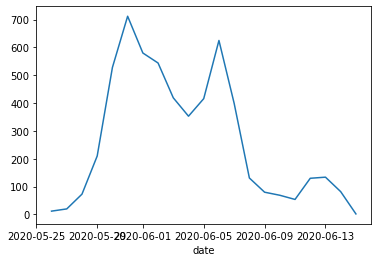

In [46]:
df_cd.groupby('date')['events'].sum().plot();

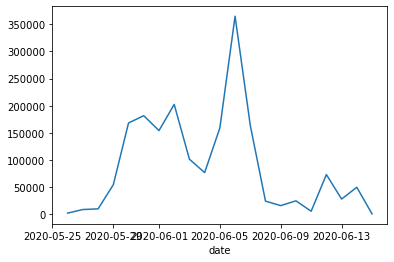

In [47]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [48]:
df_cd['size_imp'].count()

5016

In [49]:
display('Events:',df_cd['events'].sum())

'Events:'

5573

In [50]:
display("Size:",df_cd['size_imp'].sum())

'Size:'

1870944.3

In [51]:


df_cd['size'].describe()

count     2703.000000
mean       682.760377
std       3134.840537
min          1.000000
25%        100.000000
50%        200.000000
75%        400.000000
max      96950.000000
Name: size, dtype: float64

In [52]:
display(df_cd.groupby(["CCC", "Count Love", 'Elephrame','New York Times','Wikipedia'])['events'].count().reset_index())

,CCC,Count Love,Elephrame,New York Times,Wikipedia,events
0,0,0,0,0,1,153
1,0,0,0,1,0,1104
2,0,0,0,1,1,131
3,0,0,1,0,0,210
4,0,0,1,1,0,50
5,0,0,1,1,1,15
6,0,1,0,0,0,732
7,0,1,0,0,1,31
8,0,1,0,1,0,356
9,0,1,0,1,1,94


In [53]:
df_cd['city_st'].value_counts().to_frame().reset_index().sort_values(by='index').to_csv('cities.csv')